# Goal

**Here I will test a series of models predicting whether or not a customer churns with GridSearchCV in order to determine: best model combined with best parameters. This is simply via measurement of accuracy. Other metrics _must_ always be assessed to determine model performance.**

**This will be a quick run through to highlight the ease and simplicity of sklearn -- machine learning is fun!** 

In [5]:
import pandas as pd
import numpy as np

In [6]:
# Quick Inspection 
D = pd.read_csv('telco_dat.csv',delimiter=',')
D.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**A quick check of label distribution**

In [9]:
print("Yes distribution",len(D[D.Churn == 'Yes'])/len(D))
print("Number of samples",D.shape[0])

Yes distribution 0.2653698707936959
Number of samples 7043


**The label distribution is a little unbalanced with a 26% to 34% split. The size of the dat is also small.**

**Next, dropping features that aren't necessary. In this quick example, TotalCharges is likely correlated with MonthlyCharges, hence it was dropped. Categorical variables are then binarized.** 

In [10]:
X = D.drop(['customerID','Churn','TotalCharges'],axis=1)
y = pd.Series([-1]*len(X))
y[D.Churn == 'Yes'] = 1
X_ = pd.get_dummies(X)
X_.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,0,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0


**Constructing the model selection process with an object to coordinate smooth transition of process flow**

In [11]:
class EstimatorSelectionHelper:

    import pandas as pd
    import numpy as np

    
    def __init__(self, models, params):
        from sklearn.model_selection import GridSearchCV
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: {}".format(missing_params))
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}


    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring='accuracy', refit=False):
        from sklearn.model_selection import GridSearchCV
        for key in self.keys:
            print("Running GridSearchCV for {}.".format(key))
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

**Defining the models and selected parameters.**

In [12]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models_class = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
       'SVC':LinearSVC()    
}

params_class = {
    'AdaBoostClassifier':  { 'n_estimators': [50, 100,200] },
    'GradientBoostingClassifier': { 'n_estimators': [70,80,90,100], 'learning_rate':[0.01,0.1,1]},
    'SVC': {'C':[0.001,0.01, 0.1, 1,10],'penalty':['l1'],'dual':[False],},
}


In [13]:
helper_class = EstimatorSelectionHelper(models_class, params_class)
helper_class.fit(X_,y)

Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    2.7s finished


Running GridSearchCV for SVC.
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   11.6s finished
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    2.4s finished


**Printing the summary sorted by max score. Our SVC and GradientBoostingClassifier are top scorers.** 

In [9]:
helper_class.score_summary()

AdaBoostClassifier
GradientBoostingClassifier
SVC


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,C,dual,learning_rate,n_estimators,penalty
17,SVC,0.802811,0.804345,0.806218,0.00141154,0.1,False,NaN,NaN,l1
16,SVC,0.800256,0.804345,0.809199,0.0036912,0.01,False,NaN,NaN,l1
8,GradientBoostingClassifier,0.800256,0.804202,0.810051,0.00421905,NaN,NaN,0.1,80,NaN
7,GradientBoostingClassifier,0.7977,0.804061,0.811755,0.00581472,NaN,NaN,0.1,70,NaN
9,GradientBoostingClassifier,0.800256,0.803918,0.810477,0.00464821,NaN,NaN,0.1,90,NaN
10,GradientBoostingClassifier,0.798892,0.802782,0.809199,0.00457149,NaN,NaN,0.1,100,NaN
19,SVC,0.800681,0.802357,0.803237,0.00118535,10,False,NaN,NaN,l1
18,SVC,0.800681,0.801931,0.802811,0.00090782,1,False,NaN,NaN,l1
0,AdaBoostClassifier,0.800256,0.801789,0.802727,0.00109337,NaN,NaN,NaN,50,NaN
1,AdaBoostClassifier,0.799744,0.800653,0.801533,0.000730578,NaN,NaN,NaN,100,NaN


**Now, let's formally test our two winning classifiers with train_test_split and normalisation.** 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_,y,test_size=0.3)

# Scale data 
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

**Build the models and acquire the probabilities**

In [16]:
from sklearn.calibration import CalibratedClassifierCV

model_boost = GradientBoostingClassifier(learning_rate=0.1,n_estimators=80).fit(X_train,y_train)
model_svm = CalibratedClassifierCV(base_estimator=LinearSVC(C = 0.01,penalty='l1', dual=False), cv=5).fit(X_train,y_train)

y_svm_pred_proba = model_svm.predict_proba(X_test)[:,1]
y_boost_pred_proba= model_boost.predict_proba(X_test)[:,1]

**Plot! Both are very accurate classifiers.**

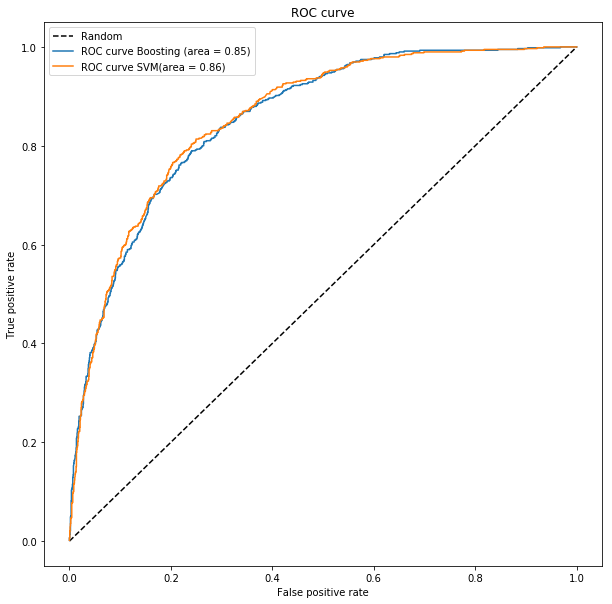

In [18]:
from sklearn.metrics import roc_curve , auc
import matplotlib.pyplot as plt

fpr_boost, tpr_boost, _ = roc_curve(y_test, y_boost_pred_proba)
roc_auc_boost=auc(fpr_boost,tpr_boost)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm_pred_proba)
roc_auc_svm=auc(fpr_svm,tpr_svm)
#Now Draw ROC using fpr , tpr
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--',label='Random')
plt.plot(fpr_boost,tpr_boost,label='ROC curve Boosting (area = %0.2f)' %roc_auc_boost)
plt.plot(fpr_svm,tpr_svm,label='ROC curve SVM(area = %0.2f)' %roc_auc_svm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


**Finally, let's check the output of our estimators based on a classification report.**

In [20]:
from sklearn.metrics import classification_report

y_pboost = model_boost.predict(X_test)
y_psvm = model_svm.predict(X_test)

print("BOOSTING REPORT")
print(classification_report(y_test,y_pboost))
print('\n\n')
print("SVM REPORT")
print(classification_report(y_test,y_psvm))

BOOSTING REPORT
             precision    recall  f1-score   support

         -1       0.83      0.92      0.87      1523
          1       0.71      0.51      0.59       590

avg / total       0.79      0.80      0.79      2113




SVM REPORT
             precision    recall  f1-score   support

         -1       0.83      0.92      0.87      1523
          1       0.71      0.53      0.61       590

avg / total       0.80      0.81      0.80      2113



# Conclusion

**In conclusion, our SVM classifier is better than the boosting model. Due to inbalanced data, our model suffers from low recall -- not providing relevant class labels. 50% of the positive samples are not considered relevant leading to a large loss of information in the model. A more balanced data set is one suggestion, as the models predict well, however anxiously and prone to false positives.**

# Final Word

**This was a quick run through to highlight the ease and usability of such extensive learning packages such as, sklearn. With a large number of tools, the problem is reduced to a few lines of code. It's not always essential to hand-pick, perfectly tune, or build a large neural network. In this case, our model was quickly computed and the entire notebook took an hour to write. "There is no such thing as free lunch" is a popular quote most famously heard in Machine Learning courses around the world -- and there's a good reason for it! A model is a trade-off and takes work and fine tuning to overcome hurdles such as: overfitting, and misclassification. When one can run a quick and dirty test to clear the path for the right model. Finally, data is contextual and to sum it up in one final quote, "let the data sing to you."**

**Enjoy the Machine Learning process, enjoy the learning experiences of failure, and enjoy unlocking patterns hidden within data -- let it "sing" to you!** 